In [1]:
#this is the import part. Most of the packages you need to use for this hw is already written here. 
# If you want you can important other packages, however it is not necessary.
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [2]:
# Note on autoreload: This allows you to make changes in python files and whenever you make a change
# they will be automatically made available inside this jupyter notebook.
# This allows you to interactively test software that you implement within your jupyter notebook
%load_ext autoreload
%autoreload 2

# HW4: High Dynamic Range Imaging and Tone-mapping (15 Points)

The goal of this homework is to explore the dynamic range properties of images captured by a single camera sensor. You will be provided with several datasets which consist of a sequence of images captured with the same camera and scene , but with different exposure settings. You will write a program to  use these images and their exposure times to find the camera response curve, recover the true irradiance image for the scene, and apply a tone-mapping algorithm to visualize this final image.

Read more on HDR-imaging at the following links:
1. https://www.pauldebevec.com/Research/HDR/
2. The original paper: https://www.pauldebevec.com/Research/HDR/debevec-siggraph97.pdf ( Please read through it at least once)

# How to complete this assignment
<span style="color:white">*To complete the assignment, you will solve 5 problems, each of which consists of a coding task and a writing task that is documented in this notebook. To achieve a passing grade, you must succesfully complete all of the coding tasks AND you must write up your results in a well-documented report.* </span>   

## <span style="color:red">Coding Tasks: </span>
You will implement functions in the following python files:
- src/loaddata.py
- src/recradmap.py
- src/tonemapping.py

## <span style="color:blue">Writing Tasks: </span>
You will writeup your results in a latex report that should document:

1. Abtract: Explain in your own words (4-5 sentences) the core problem of High-Dynamic-Range imaging
2. Introduction: Introduce the problem of HDR-imaging. Read through the original HDR-paper by Paul Debevec and summarize in a few sentences (~10 sentences)
    - What is the problem? Why can't you capture an HDR image with a normal camera with only one exposure?
    - What is the core idea behind the HDR-imaging technique?   
3. Method: Tone-Mapping (5-10 sentences) - read more on reinhard tone-mapping inside the notebook
    - Why do you require tone mapping? What is the problem?
    - How does Reinhard tone mapping work? 
4. the results you achieved, including figures generated in this notebook after you have completed the coding tasks.

Please refer to the latex template for your writeups

In [3]:
# Import the function that you'll need to implement

In [4]:
from src import loaddata 
from src import gsolve
from src import tonemapping
from src import recradmap

# <span style="color:orange">1. Load exposure bracketing sequences from the "data" folder </span>

The "data" folder contains a set of exposures for a few different scenes, where filenames are given by the exposure time in seconds. Please notice: When you're using OpenCV to read the images, the loaded $m \times n \times 3$ matrix are in BGR instead of the RGB channel we're familiar with.

## <span style="color:red">Coding Task: Implement load data</span>

You will implement the following functions in function in *src/loaddata.py*. You will need to write code to load all of the images in a folder within the "data" folder of this repository. You will also need to write code to parse the exposure time, which is provided as the name of the files in the folder  
- loaddata()

## <span style="color:blue">Writing Tasks: </span>
Describe the dataset that has been provided and the code you implemented to load the dataset. Include figures for the following:
- Example images displayed in a grid for two different datasets within the "data" folder



You should first load the "memorial" dataset from Paul Debevec's paper - use this dataset to start playing around with recovering response curves and completing Problems 2-5.

In [5]:
imgFolder = 'data//memorial//'

Load the raw images and exposure times from the "data" folder 

In [6]:
rawImg,exposure_time = loaddata.loadImage(imgFolder= imgFolder)
log_exposure_time = np.log(exposure_time)
print(rawImg.shape) # should be [ DimX DimY 3 Num_Images]
print(rawImg.dtype) # raw images should be uint8
print(exposure_time.shape) # should be [Num_Images,]

(768, 512, 3, 13)
uint8
(13,)


crop image around boundaries to avoid any border effects from registration

In [7]:
rawImg = rawImg[25:-25,25:-25,:,:]
print(rawImg.shape)

(718, 462, 3, 13)


Then plot the images in a grid

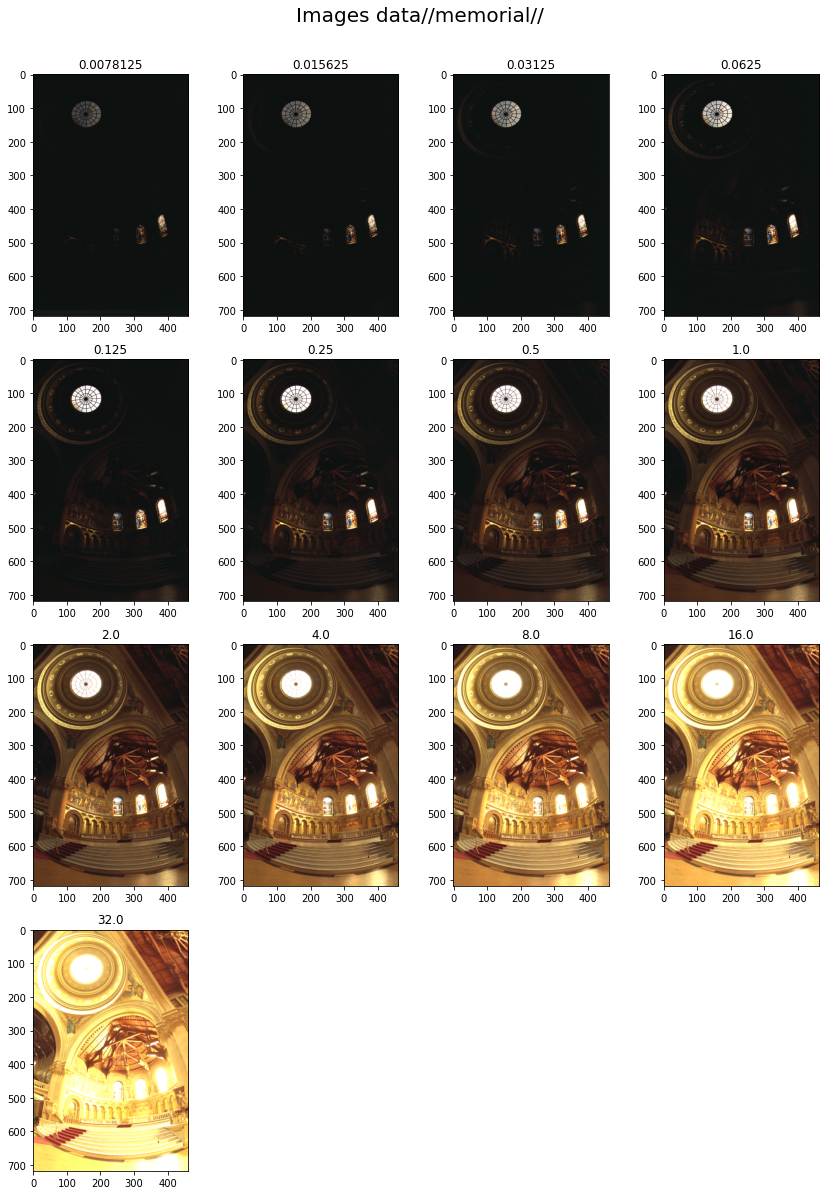

In [8]:
idx = 1
m_plots = 8
n_plots = 4
plt.figure(figsize=(12,32)) # If you load a different dataset please adapt the size so that it looks good

plt.suptitle("Images " + imgFolder,fontsize=20,y=1.005)
for k in range(rawImg.shape[3]):
    plt.subplot(m_plots,n_plots,idx);idx = idx + 1
    plt.imshow(rawImg[:,:,:,k])
    plt.title(exposure_time[k])
plt.tight_layout()

loaddata.save_fig_as_png("images_memorial")

# <span style="color:orange">2. Write a program to find the camera response curves</span>


The camera response function (CRF) gives us the connection between the scene radiance to the measured intensity values. The CRF if of great importance in some computer vision algorithms, including HDR algorithms. Here we estimate the inverse camera response function and use it for the HDR merge.

We can model the brightness measured by the ith pixel during the jth exposure as:

<h3>$$Z[i,j]=f(E[i]\cdot B[j]) (1)$$</h3>
    
where $E[i]$ is the actual irradiance incident on the ith pixel, $B[j]$ is the exposure time of the jth captured image, and $f$ is the camera response function that maps exposure values to digital numbers (usually in the range 0-255). Defining $g(x)=ln(f^{-1}(x))$, we can write

<h3>$$g(Z[i,j])=ln(E[i])+ln(B[j]) (2)$$</h3>

You will use the method from Devevec et al.[1] to recover the response curve $g(Z)$ for values in the range[0,255]. You do not need to implement the gsolve function - it is provided for you in src/gsolve.py 

Once you solve for your inverse response curve, it should look something like below:

<center><img src="https://compphotolab.github.io/cs331/HW4/HW4_files/image015.png" style="float:middle" /></center>

IMPORTANT: DO NOT USE ALL THE PIXELS IN THE IMAGE TO SOLVE FOR THE RESPONSE CURVE! This will be extremely slow. Instead, you can choose a random subset of 100-1000 pixels to use as input to gsolve.

## <span style="color:red">Coding Task: </span>

You will implement the following functions in function in *src/load_data.py* and *src/gsolve.py* 
- create_measured_Z_values() - sample a subset of the Z values from the captured images dataset.
- plotCurve() - plot the curve of the solved G function and the measured pixels
- plotCurves() - plot the response curves for each color channel

## <span style="color:blue">Writing Tasks: </span>
Here are some guidelines for the writing portion of this problem:

- You will need to choose a value for the regularization parameter $\lambda$. Try a few different values in the range [1,1000]. How does adjusting this parameter affect the result you get for the response curve? Report several results for different regularization (lambda) parameters in your final report. Discuss shortly why you've chosen the one you've chosen and why you have rejected the others. Try to make some arguments that include a "pseudo-physical" explanation

- You will write code to generate figures for the response curves for the green, blue and red channels independently. Once you run gsolve.m successfully, you will be given two outputs, the response curve g and the recovered log radiance $ln(E[i])$ for each of the pixels that you input to the algorithm. Plot the recovered values for $g(z)$ versus the valid range of pixel values [0,255]. Do this for each of the red, green and blue channels and include in your report. 

- In the same figure, you will also include a plot of the log exposure for each of the pixels used as input to gsolve.m. To generate this plot, take the measured pixel value for each pixel $Z[i,j]$ and plot it against the sum of the recovered log irradiance and log exposure time, for each pixel. Describe how well you are able to fit the inverse response function $g(z)$ using this procedure.

In [9]:
numSample = 1000
brightness = loaddata.create_measured_Z_values(rawImg, numSample=numSample, low=0, high=245)

print(brightness.shape) # Should be (numSample, numImages, 3)

(1000, 13, 3)


[[ 15.31   19.032  17.396]
 [ 16.134  19.571  17.855]
 [ 17.366  20.852  18.805]
 [ 20.085  22.535  20.239]
 [ 24.493  24.25   21.631]
 [ 33.422  28.484  24.495]
 [ 47.072  35.243  28.208]
 [ 66.164  46.638  33.544]
 [ 91.385  63.362  41.233]
 [123.101  86.705  52.468]
 [158.926 115.363  66.779]
 [197.846 152.11   87.298]
 [226.958 188.869 112.231]]


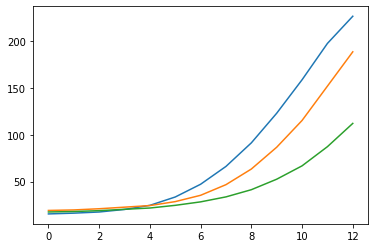

In [10]:
# Think about of the values in brigthness are reasonable

# These statistics might help you:

print(brightness.mean(axis=0))
plt.plot(brightness.mean(axis=0))

Run the gsolve function to recover the inverse response function $g(Z)$ for each color channel

In [11]:
λ = 1000

solveG = np.zeros((256,3))
log_exposure = np.zeros((numSample,3))

# solve g (inverse of f function) and plot the relationship between radiance and pixel value.
for k in range(3):
    solveG[:,k], log_exposure[:,k] = gsolve.gsolve(brightness[:,:,k], log_exposure_time, λ)

In [12]:
print(solveG.shape) # should be (256,3)
print(log_exposure.shape) # should be (numSample, 3)

(256, 3)
(1000, 3)


plot the fitted inverse response curves against the data used for the fitting procedure

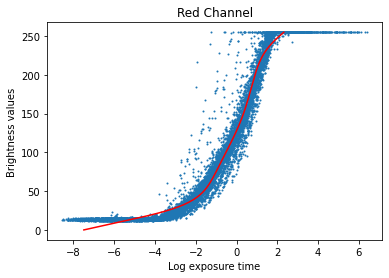

In [13]:
# Let's plot it for one channel first, after you can use this for the subplot for all channels:
k = 0
gsolve.plotCurve(solveG[:,k],log_exposure[:,k],log_exposure_time,brightness[:,:,k],'Red Channel')

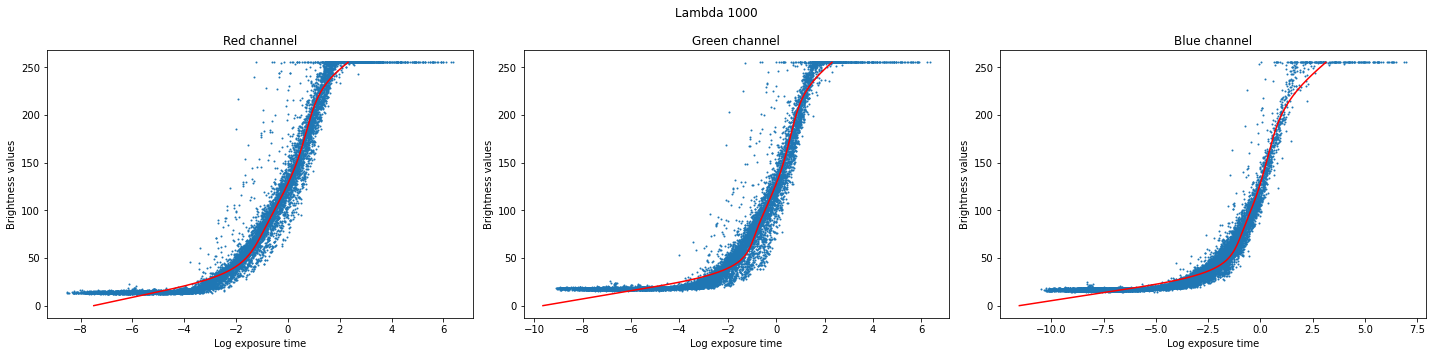

In [14]:
plt.figure(figsize=(20,5))
gsolve.plotCurves(solveG, log_exposure, log_exposure_time, brightness,λ)
plt.tight_layout()
loaddata.save_fig_as_png("response_curve_lamba_1000")

# <span style="color:orange">3. Recover the HDR radiance map of the scene</span>

Once you have recovered the camera response curve you are now ready to recover a radiance image from your sequence of exposures. You can recover the radiance map using the following equation
$$ln(E[i])=\frac{1}{P}\sum_{j=1}^{P}(g(Z[i,j])-ln(B[j]))$$
Where $P$ is the number of images that you captured in part 1). 

Your result should look something like this
<br>

<center><img src="https://compphotolab.github.io/cs331/HW4/HW4_files/image018.png" style="float:middle" /></center>

## <span style="color:red">Coding Task: </span>

You will calculate the radiance map using the equation above, then plot the output of the function, which is the recovered radiance map of the scene. You will implement the following functions in function in *src/recradman.py* 
- get_log_radiance_map() - use the recovered response curves to recover the radiance map from the captured image dataset.
- plotRadMap() - plot images of the recovered radiance map for each color channel

## <span style="color:blue">Writing Tasks: </span>
Here are some guidelines for the writing portion of this problem:

-  Show a plot of the radiance image recovered from the image sequence for two different datasets. What is the dynamic range of the scene? For example, i.e. the dynamic range of the memorial scene is nearly 10^6 or 1,000,000:1.

In [15]:
# Hint:
# The raw images have intensities between 0,255.
# Now what is the gsolve function? It's an array of length 256
# So instead of looping through each pixel you can just plug the images into the gsolve array
# And you immediately get out what you need ?! 
# Think about this first before you write a very inefficient method !!!
# Try to avoid for-loops that iterate over the pixels at any cost. For-loops to iterate through the channels and number of images are ok!

log_radiance = recradmap.get_log_radiance_map(rawImg, log_exposure_time, solveG)

In [16]:
# Now write a function to visualize the radiance map. For convenience of the reader plase plot it into one image
# Note: You can use the helper for function from the Noise homework to deal with issues of a too large scalebar
# Note: Use grayscale images over color images
print(log_radiance.shape)

(718, 462, 3)


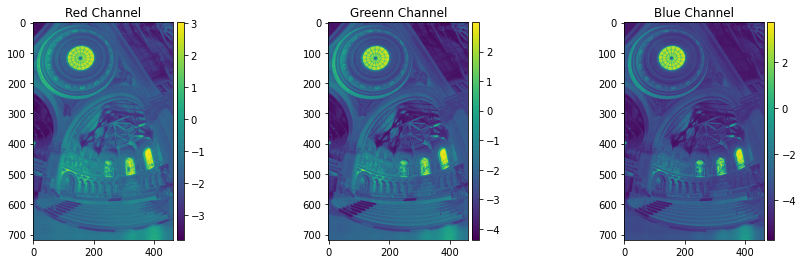

In [17]:
plt.figure(figsize=(15,4))
recradmap.plotRadMap(log_radiance)

loaddata.save_fig_as_png("HDR_radiance_map")

# <span style="color:orange">4. Implement a tone mapping algorithm to display your HDR image</span>

The radiance map you recovered in Problem (3) likely has a much larger dynamic range than any electronic display device you will use to view the image. You now need to apply a simple global tone-mapping algorithm to your radiance image so that you can visualize the scene in a perceptually compelling way. You will implement two different tonemapping algorithms, gamma correction, and a perceptually inspired tonemapping algorithms from Reinhard et al. You can read more on the Reinhard Tone Mapping Operator here:
https://expf.wordpress.com/2010/05/04/reinhards_tone_mapping_operator/  

### 4.1 Scale Brightness
In this section, you need to complete the function scaleBrightness that normalizes the radiance map to values between 0 and 1 using the equation below:

<br>
$$E_{norm}[i]=\frac{E[i]-E_{min}}{E_{max}-E_{min}} (4)$$

Note that you will need to normalize each color channel independently, so for each of the R,G,B channels of your recovered radiance map $E[i] = {R[i], G[i], B[i]}$ you will compute

$$R_{norm}[i]=\frac{R[i]-R_{min}}{R_{max}-R_{min}} $$
$$G_{norm}[i]=\frac{G[i]-G_{min}}{R_{max}-G_{min}} $$
$$B_{norm}[i]=\frac{B[i]-B_{min}}{R_{max}-B_{min}} $$

Normalizing each of your color channels independently will help ensure that errors in the the camera response curves don't change the color balance of your tonemapped radiance maps.  

## <span style="color:red">Coding Task: </span>

Implement the following functions in function in *src/tonemapping.py* 
- scaleBrightness()

## <span style="color:blue">Writing Tasks: </span>

-  Show Figures for the normalized radiance images for each color channel using a grayscale color map for two datasets. What do these images look like? What is the problem with visualizing the radiance maps this way? 

In [18]:
# you need to first convert from log_radiance to radiance!!!
radiance = np.exp(log_radiance)
radiance_normalized = tonemapping.scaleBrightness(radiance)

print(radiance_normalized.shape)  # Should be (numX, numY, 3)
print(radiance_normalized.dtype) # Should be float64

(718, 462, 3)
float64


generate some figures of normalized color channels to include in your writeup

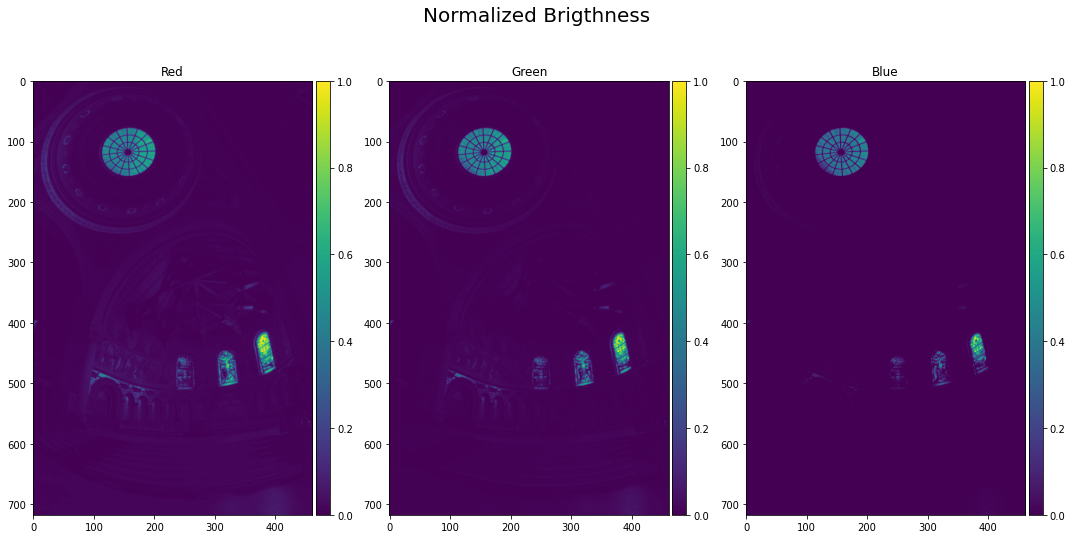

In [19]:
plt.figure(figsize=(15,8))

def plot_3_channels(radiance_normalized,title=""):
    colors = ["Red","Green","Blue"]

    plt.suptitle(title,fontsize=20)
    for k in range(3):
        plt.subplot(1,3,k+1)
        recradmap.plot_with_colorbar(radiance_normalized[:,:,k],colors[k])
    plt.tight_layout()
    
plot_3_channels(radiance_normalized,"Normalized Brigthness")

loaddata.save_fig_as_png("normalized_brigthness")

### 4.1 Apply gamma adjustment

Next apply a gamma curve to the radiance map. To do this simply raise the irradiance of each pixel to the with an exponent of $\gamma$. 

$$E_{gamma}[i]=E[i]_{norm}^{\gamma}(5)$$ 

Play with different values for $\gamma$ and report your results. Can you find a value that gives you visually pleasing results?

## <span style="color:red">Coding Task: </span>

Implement the following functions in function in *src/tonemapping.py* 
- apply_gamma_curve()

## <span style="color:blue">Writing Tasks: </span>
Play with different values for $\gamma$ and report your results. Which value of $\gamma$ gives you the most visually pleasing results? Compare the gamma mapped results with the individual exposures in the dataset that you visualized in Problem (1) above. Does your gamma mapped results succesfully fuse information from all exposures? Include Figures for:
- output of plot_3_channels() for a few different $\gamma$ values
- visualization of RGB image using plt.imshow() for a few different $\gamma$ values

(718, 462, 3)
float64


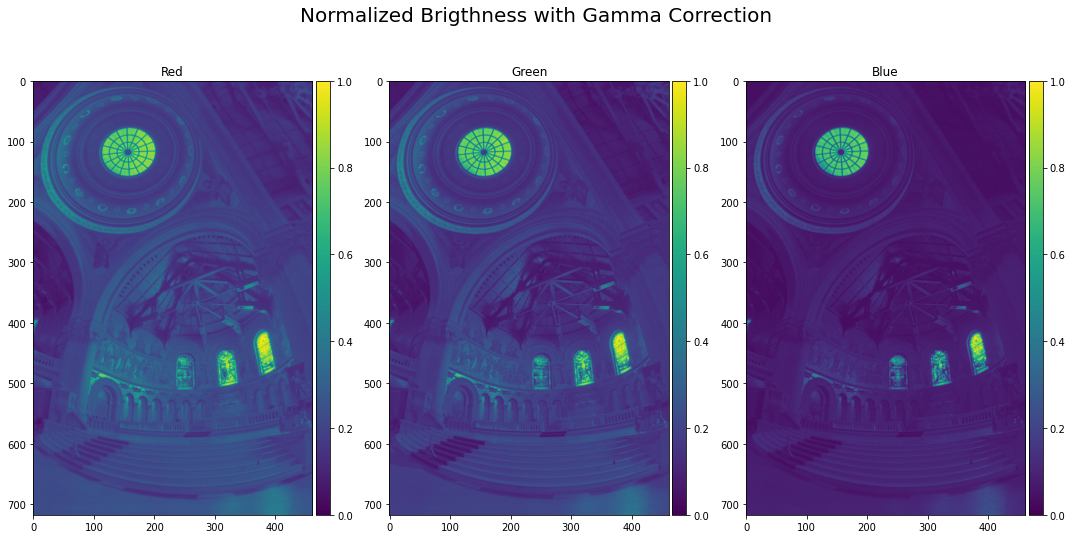

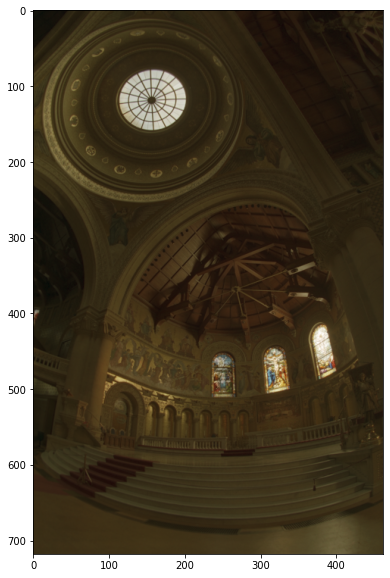

In [20]:
radiance_gamma = tonemapping.apply_gamma_curve(radiance_normalized, gamma= 0.33)

plt.figure(figsize=(15,8))
plot_3_channels(radiance_gamma,"Normalized Brigthness with Gamma Correction");
print(radiance_gamma.shape) # Should be (numX, numY, 3)
print(radiance_gamma.dtype) # Should be float64

loaddata.save_fig_as_png("normalized_brigthness_gamma_correction")

plt.figure(figsize=(20,10));
plt.imshow(radiance_gamma);

loaddata.save_fig_as_png("radiance_gamma")

### 4.3 Implement Reinhard Tone Mapping

Lastly, you will implement the global tone mapping operator from Reinhard '02 [2]. First you will need to convert the radiance image from color to grayscale. Note that you will first need to normalize the image using Eq. (4). 

Read more on tone mapping here:
1. https://www.cl.cam.ac.uk/~rkm38/pdfs/tone_mapping.pdf
2. PDF to original paper: http://www.cmap.polytechnique.fr/~peyre/cours/x2005signal/hdr_photographic.pdf ( Read through it at least once to get an idea)

$$L[i]=rgb2gray(E_{norm}[i])(6)$$

Then use the following equations to implement the tone mapping. We first calculate the log average exposure

$$L_{avg}=exp(\frac{1}{N}\sum_{i}ln(L[i]))(7)$$

Where the summation is over all of the pixels in the luminance image. Next scale the image according to:

$$T[i]=\frac{a}{L_{avg}}L[i](8)$$

Where $a$ is a parameter (the 'key') that can be tuned for best visual appearance. Next apply the Reinhard tone-mapping operator:

$$L_{tone}[i]=\frac{T[i] \cdot (1 + \frac{T[i]}{T_{max}^{2}})}{1 + T[i]}(9)$$

Note that, like the gamma mapping, the Reinhard tonemapping operator also maps radiance values in the range $[0,1]$. Finally, define the scaling operator

$$M[i]=\frac{L_{tone}[i]}{L[i]}(10)$$

and use this to scale each of the color channels in the radiance image. If the red, green, and blue channels of the radiance image are R, G, and B, form a new RGB image according to:

$$R_{HDR}[i]=M[i]\cdot R_{norm}[i]$$ 
$$G_{HDR}[i]=M[i]\cdot G_{norm}[i]$$ 
$$B_{HDR}[i]=M[i]\cdot B_{norm}[i]$$ 

In which the R, G, B represents the normalized RGB channels of the radiance map from Equation (4).

## <span style="color:red">Coding Task: </span>

Implement the following functions in function in *src/tonemapping.py*. Note that before you visualize your images, you need to proces them with the clip_hdr function provided in *src/tonemapping.py*, which ensures that the resulting tonemap displays correctly using plt.imshow().
- convert_rgb2gray() - convert rgb radiance map to luminance/grayscale only
- tonemapping() - compute the scaling function to multiply by each color channel

## <span style="color:blue">Writing Tasks: </span>
Play with different values for the 'key' $a$ in the tonemapping operator. Start with a value of $a=.18$, then you can experiment with values in the range $[.01, .4]$. How does the choice of 'a' effect your results? How do the results compare against the best choice of $\gamma$ from the above problem? Does your tonemapped results allow you to visualize more information from the original exposure sequence? Include Figures for:
- visualization of scaling function $M$ computed from two different datasets.
- output of plot_3_channels() for a few different 'key' $a$ values for two different datasets
- visualization of RGB tonemapped images using plt.imshow() for a few different $a$ values and two different datasets

(718, 462)


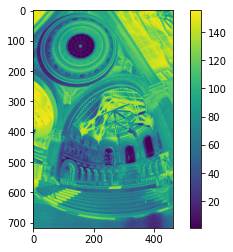

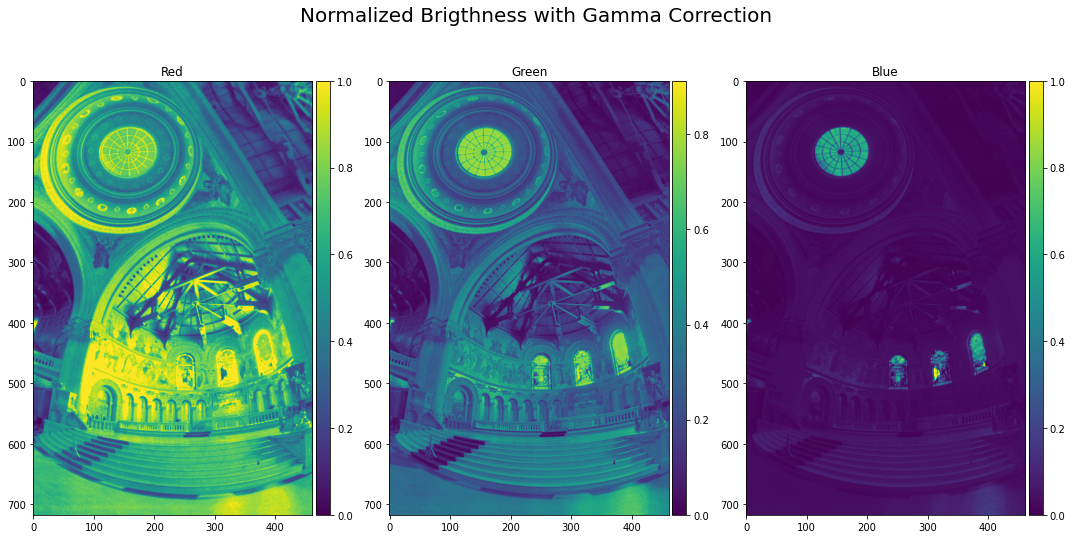

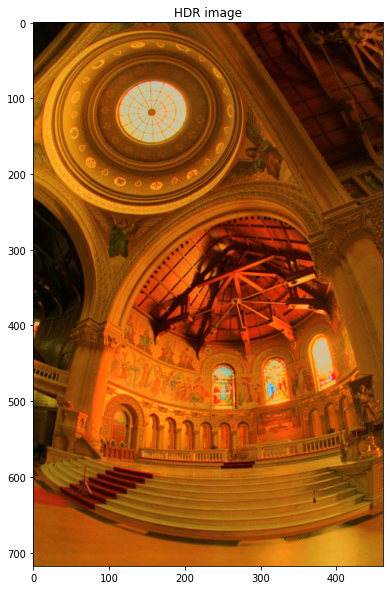

In [25]:
radiance = np.exp(log_radiance)

radiance_normalized = tonemapping.scaleBrightness(radiance)
# first compute the scaling function M from the normalized radiance map and then visualize the results
M = tonemapping.tone_mapping(radiance_normalized,a=0.8)
print(M.shape) # Should be (numX, numY)


loaddata.save_fig_as_png("tonemapping_image")

plt.imshow(M)
plt.colorbar()

# compute the tonemapped image by multiplying each color channel by the scaling function M
# Note that M.shape = (numX, numY) and radiance_normalized.shape = (numX, numY, 3)
# M[:,:,None] is shorthand for multiplying the (numX, numY) values by each of the 3 
# color channels in radiance_normalized  
hdr =  radiance_normalized * M[:,:,None]

# you need to clip the tonemapped result to ensure that it displays correctly with plt.imshow()
hdr,_,_ = tonemapping.clip_hdr(hdr)

plt.figure(figsize=(15,8))
plot_3_channels(hdr,"Normalized Brigthness with Gamma Correction")

loaddata.save_fig_as_png("channels_after_tonemapping_correctin")


plt.figure(figsize=(10,10))
plt.imshow(hdr);
plt.title("HDR image")

loaddata.save_fig_as_png("hdr_image")


# 5. Test your tonemapping algorithm on a few different datasets 

Now that you have implemented your data loading, response curve recovery, and tonemapping algorithm, you will package it into a single function and compare results across a few different datasets

## <span style="color:red">Coding Task: </span>

Implement the following functions in function in *src/tonemapping.py*. You will just be copying your results from Problems (2)-(4) above into a single function so it is convenient to run on a number of datasets.
- compute_hdr_image() - compute gamma and tonemapped radiance maps from a loaded image dataset

## <span style="color:blue">Writing Tasks: </span>
Experiment with different key values $a$ and gamma values $\gamma$ for your tonemapped results. Try to choose values that work well for all the images in the dataset - the default values in the notebook below should be a good starting point. Run your code a couple of times while keeping the values fixed - do the results change at all, and if so Why? Does one of the tonemapping operators consistently perform better than the other? Do the results depend on the dataset at all? Include Figures for:
- visualization of RGB gamma adjusted and Reinhard tonemapped images using plt.imshow() for each of the four different datasets given

In [26]:
folders = ['desktop02', 'scene', 'memorial', 'digimax_gate']

### First implement the compute_hdr_image on one image-set. After we will loop through all images

In [27]:
imgs,expTime = loaddata.loadImage("data//"+folders[0]+"//")
imgs = imgs[25:-25,25:-25,:,:]

hdr,radiance_gamma = tonemapping.compute_hdr_image(imgs,expTime, lam = 1000, gamma = 0.3, a = 0.3)

### Now run the compute_hdr_image on all the images in the folder array

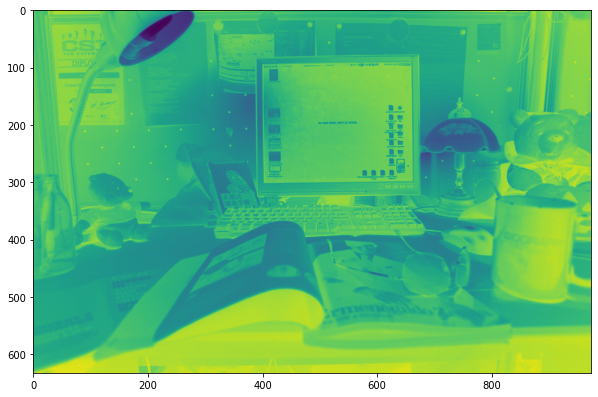

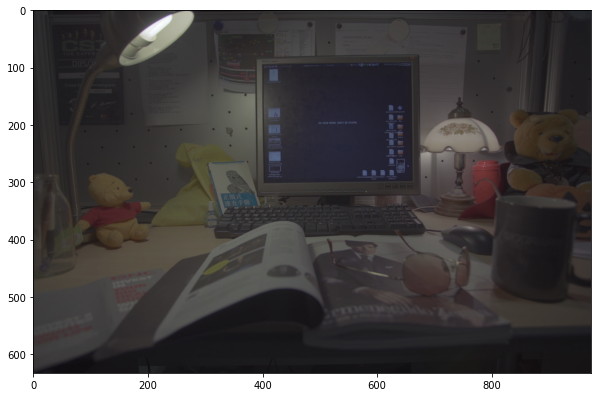

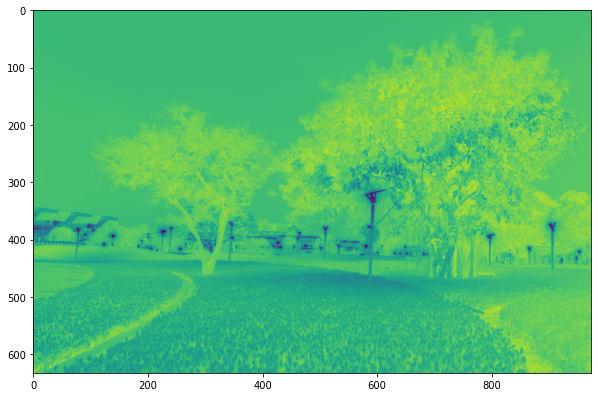

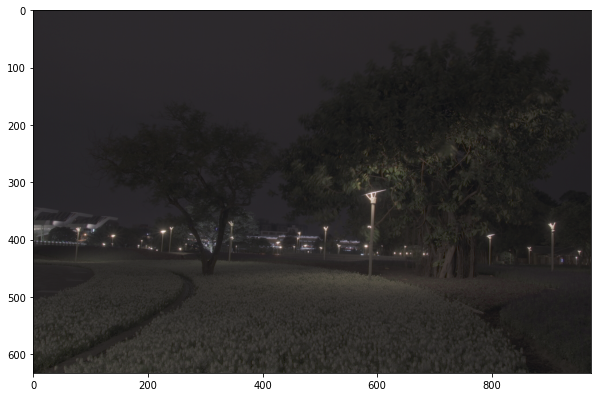

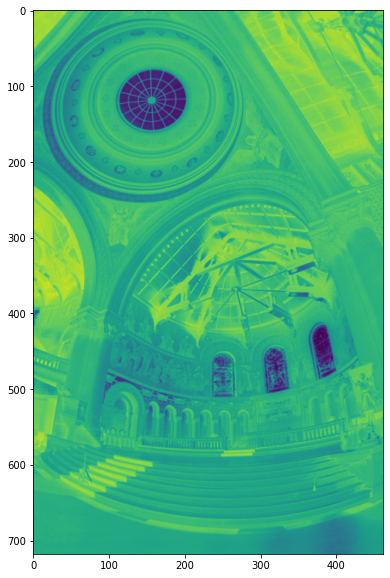

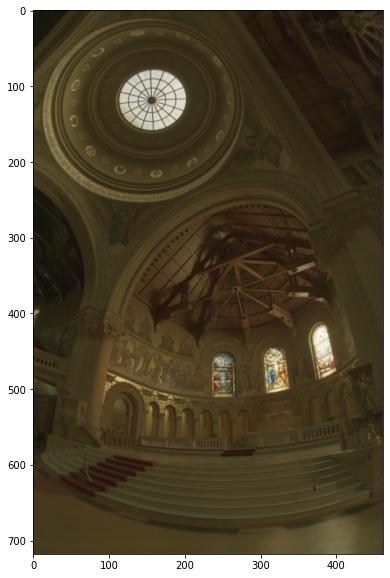

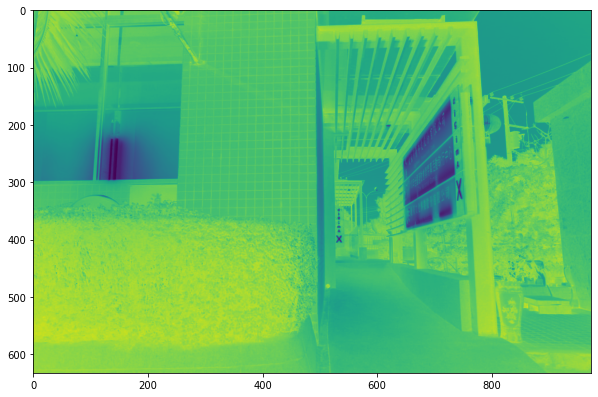

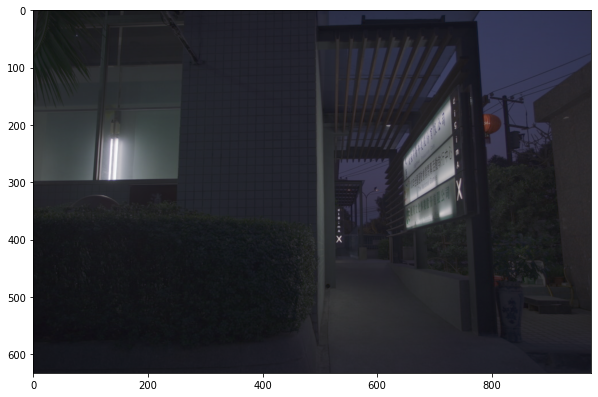

In [28]:
for folder in folders:
    imgs,expTime = loaddata.loadImage("data//" + folder + "//")
    imgs = imgs[25:-25,25:-25,:,:]

    hdr,radiance_gamma = tonemapping.compute_hdr_image(imgs,expTime, lam = 1000, gamma = 0.3, a = 0.3)
    plt.figure(figsize=(10,10))
    plt.imshow(hdr)
    loaddata.save_fig_as_png("hdr_"+folder)

    plt.figure(figsize=(10,10))
    plt.imshow(radiance_gamma)
    
    loaddata.save_fig_as_png("radiance_map"+folder)


# Bonus Challenge: Try it out on more datasets

In the data folder there are more datasets. If you want you can try to create HDR images for these data as well. However, you'll likely have to play around